In [36]:
import fastf1 as f1
import numpy as np
import pandas as pd

# from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle
import sys
sys.path.append("../..")
from prod.utils import events
from prod.utils import plotting
from prod.utils import timing

import warnings
warnings.filterwarnings('ignore')

f1.Cache.enable_cache("../../fastf1_cache")

YEAR, ROUND, EVENT = events.next_event()

In [2]:
# Load data
sesh = f1.get_session(YEAR, 1, 2)
sesh.load(messages=False)

# Get unique driver numbers from the session
driver_numbers = sesh.laps.DriverNumber.unique()

# Convert LapTime to seconds
sesh.laps["LapTime"] = sesh.laps["LapTime"] / np.timedelta64(1, "s")
sesh.laps["Colors"] = plotting.order_colors(sesh.laps["Team"])

# Get each driver's fastest lap
fastest = pd.DataFrame()
for d in driver_numbers:
    fastest = pd.concat(
        [
            fastest,
            sesh.laps[sesh.laps["DriverNumber"] == d].pick_fastest().to_frame().T,
        ],
        axis=0,
    )

core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v2.3.0]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '44', '31', '27', '24', '23', '22', '21', '20', '18', '16', '14', '11', '10', '4', '2', '77', '81']


## Lap Times

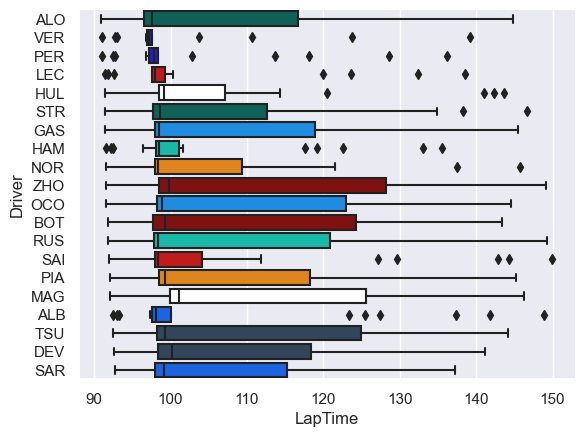

In [14]:
# Boxplot of driver laps
sns.set_theme()
order = sesh.laps.groupby(["Driver", "Team"])["LapTime"].min().sort_values().index.get_level_values("Driver").tolist()
palette = plotting.order_colors(sesh.laps.groupby(["Driver", "Team"])["LapTime"].min().sort_values().index.get_level_values("Team").tolist())
sns.boxplot(data=sesh.laps, y="Driver", x="LapTime", orient="h", order=order, palette=palette)
sns.despine()

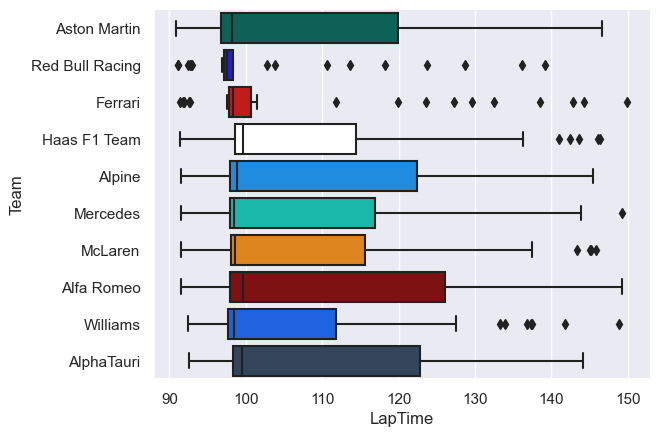

In [20]:
# Boxplot of team laps
sns.set_theme()
order = sesh.laps.groupby(["Team"])["LapTime"].min().sort_values().index.get_level_values("Team").tolist()
palette = plotting.order_colors(sesh.laps.groupby(["Team"])["LapTime"].min().sort_values().index.get_level_values("Team").tolist())
sns.boxplot(data=sesh.laps, y="Team", x="LapTime", orient="h", order=order, palette=palette)

sns.despine()

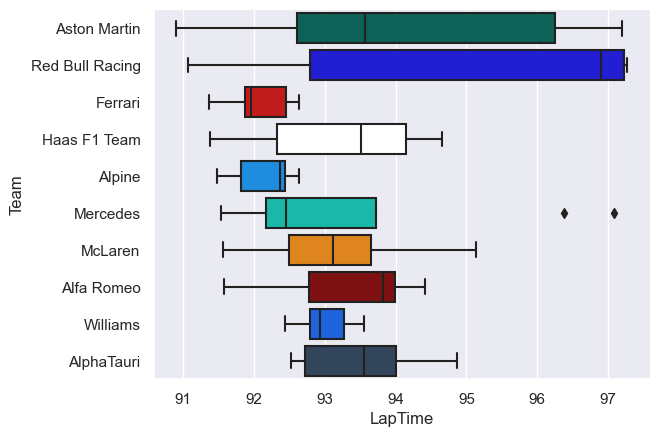

In [15]:
# Fast Laps
fast_laps = sesh.laps.loc[sesh.laps["LapTime"] < 1.07 * sesh.laps["LapTime"].min()]
sns.set_theme()
order = fast_laps.groupby(["Team"])["LapTime"].min().sort_values().index.get_level_values("Team").tolist()
palette = plotting.order_colors(fast_laps.groupby(["Team"])["LapTime"].min().sort_values().index.get_level_values("Team").tolist())
sns.boxplot(data=fast_laps, y="Team", x="LapTime", orient="h", order=order, palette=palette)

sns.despine()


## Fastest Lap

[(89.99793, 95.45235), Text(0.5, 1.0, 'Fastest Lap Times')]

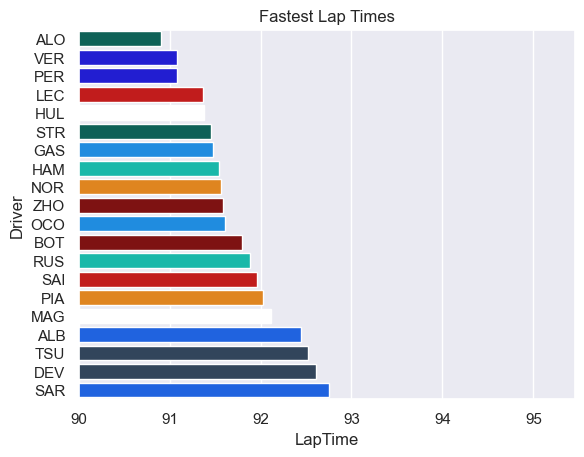

In [83]:
order = fastest.groupby("Driver")["LapTime"].min().sort_values().index.get_level_values("Driver").to_list()
map = timing.get_team_names(sesh)
palette = plotting.order_colors([map[x] for x in order])
ax = sns.barplot(data=fastest, x="LapTime", y="Driver", order=order, palette=palette)
ax.set(xlim=(fastest["LapTime"].min()*.99,fastest["LapTime"].min()*1.05), title="Fastest Lap Times")

## Top Speed

[Text(0.5, 1.0, 'Speed Trap'), (308.75, 328.25)]

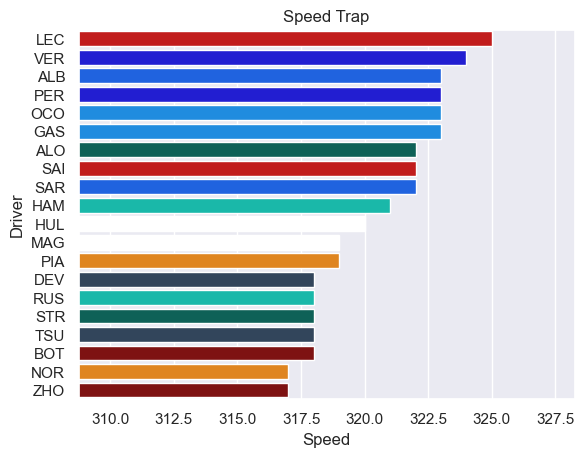

In [82]:
telem = timing.get_telem(sesh)

top_speeds = telem.groupby(["Driver", "Team"])["Speed"].max().sort_values(ascending=False)

top_speeds = top_speeds.to_frame().reset_index()

palette = plotting.order_colors([map[x] for x in top_speeds["Driver"]])

#top_speeds = pd.DataFrame(top_speeds)
ax = sns.barplot(data=top_speeds, x="Speed", y="Driver", order=top_speeds["Driver"], palette=palette)
ax.set(title="Speed Trap", xlim=(top_speeds["Speed"].max()*.95, top_speeds["Speed"].max()*1.01))

## Run Plan

<Axes: xlabel='Time', ylabel='LapTime'>

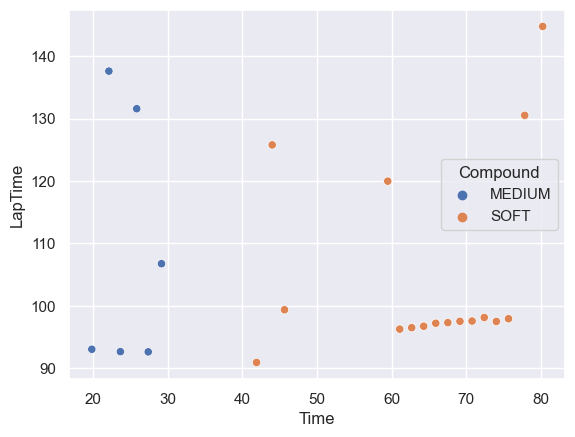

In [28]:
run_plan = sesh.laps.copy()
run_plan["Time"] = run_plan["Time"] / np.timedelta64(1, "m")
sns.scatterplot(data=run_plan.loc[sesh.laps["Driver"] == "ALO"], x="Time", y="LapTime", hue="Compound")

## Fastest Lap Telem

In [9]:
fast_lap = timing.get_telem(sesh, fastest_only=True)

In [361]:
res = pd.concat([fast_lap.loc[fast_lap["Driver"] == "NOR"]["Time"].reset_index(drop=True), 
                 fast_lap.loc[fast_lap["Driver"] == "PIA"]["Time"].reset_index(drop=True)], axis=1, keys=["NOR", "PIA"])

res["delta"] = res.iloc[:,0] - res.iloc[:,1]

res["delta"] = res["delta"] / np.timedelta64(1, "s")
res = res.dropna()
deltax = res.index
deltay = res.delta

In [362]:
# Normalize positive delta to .5 - 1
colory = deltay.copy()
tmp = colory[colory > 0]
colory[colory > 0] = .5 * ((tmp - tmp.min()) / (tmp.max()-tmp.min())) + .5
# Normalize negative delta to 0 - .5
tmp = colory[colory < 0]
colory[colory < 0] = .5 * ((tmp - tmp.min()) / (tmp.max()-tmp.min())) + 0

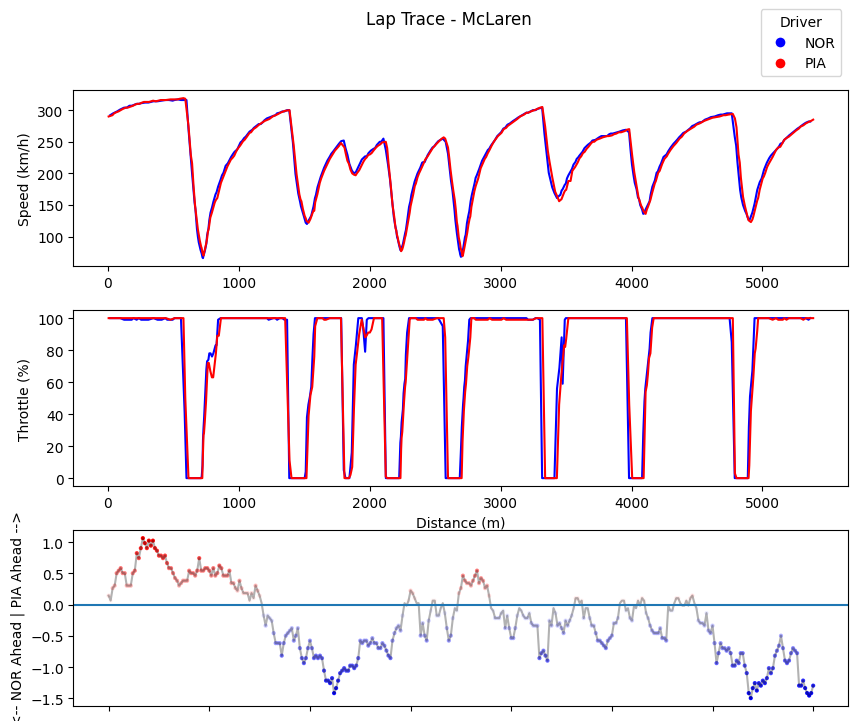

In [363]:
from matplotlib import cm

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=.25)
ax = gs.subplots()
fig.suptitle("Lap Trace - McLaren")  # TODO: {team}
fast_lap = fast_lap.loc[fast_lap.Driver.isin(["NOR", "PIA"])].reset_index(drop=True)

colors = {"NOR": "blue", "PIA": "red"}

for f in fast_lap.Driver.unique():
    df = fast_lap.loc[fast_lap["Driver"] == f]
    ax[0].plot(df.Distance, df.Speed, c=colors[f])
    ax[1].plot(df.Distance, df.Throttle, c=colors[f])

ax[0].set(ylabel="Speed (km/h)")
ax[1].sharex(ax[0])
ax[1].set(xlabel="Distance (m)", ylabel="Throttle (%)")

# Delta between cars
ax[2].scatter(x=deltax, y=deltay, c=cm.bwr(colory), edgecolor="none", marker=".", alpha=1)
ax[2].plot(deltax, deltay, alpha=.3, color="black")
ax[2].axhline(y=0)
ax[2].set_xticklabels([]) # Hide tick values, but still correspond's to index of Distance
ax[2].set(ylabel="<-- NOR Ahead | PIA Ahead -->") # TODO: Dynamic names
# TODO: Smoothe line - not easy by interpolating y values

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax[0].legend(title='Driver', handles=handles, bbox_to_anchor=(1.00, 1.5), loc='upper right')
fig.set_size_inches(w=10, h=8)